## Base Model Training

### 1. Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from Scripts.business_focused_evaluator import BusinessModelEvaluator
from sklearn.metrics import (
                            classification_report,
                            confusion_matrix,
                            accuracy_score,
                            f1_score,
                            precision_score,
                            recall_score,
                            )


### 2. Data Loading

In [2]:
X_train = np.load('../Artifacts/X_train.npz', allow_pickle=True)['arr_0']
Y_train = np.load('../Artifacts/Y_train.npz', allow_pickle=True)['arr_0']
X_test = np.load('../Artifacts/X_test.npz', allow_pickle=True)['arr_0']
Y_test = np.load('../Artifacts/Y_test.npz', allow_pickle=True)['arr_0']

### 3. Model Training

## 3.1 Logistic Regression

In [3]:
model_lr = LogisticRegression(
                            random_state=42,
                            max_iter=10000
                            )

model_lr.fit(X_train, Y_train)

LogisticRegression(max_iter=10000, random_state=42)

#### 3.1.1 Inference

In [4]:
Y_hat_test = model_lr.predict(X_test)

#### 3.1.2 Evaluation

In [5]:
accuracy = accuracy_score(Y_test, Y_hat_test)
precision = precision_score(Y_test, Y_hat_test)
recall = recall_score(Y_test, Y_hat_test)
f1_score = f1_score(Y_test, Y_hat_test)

In [6]:
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"f1_Score : {f1_score}")

Accuracy : 0.7579843860894251
Precision : 0.527972027972028
Recall : 0.8096514745308311
f1_Score : 0.6391534391534391


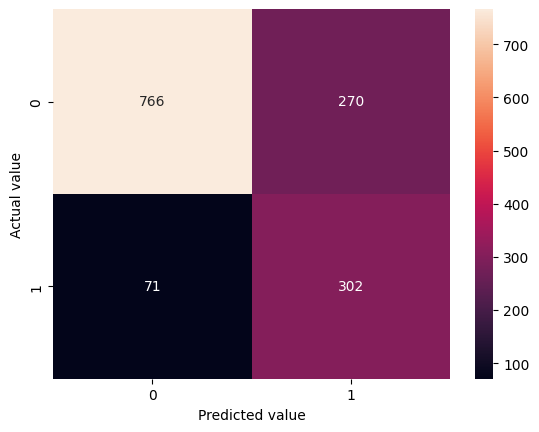

In [7]:
cm = confusion_matrix(Y_test,Y_hat_test)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.show()

#### 📏 3.1.3 Class Imbalance Considerations & Evaluation Strategy

Due to the **significant class imbalance** in our dataset, focusing solely on **accuracy** can be misleading and may lead to poor business outcomes.  
We need an evaluation strategy that reflects **true business objectives**.

---

#### ⚠ Why Accuracy Fails

- Majority class (**Non-churners**) ≈ **73%** of customers.
- A naive model that **always predicts "No Churn"** would achieve ~73% accuracy.
- However, this model would **miss all at-risk customers**, making it **useless** for churn prevention.

---

#### 💰 Business Impact of Prediction Errors

The cost of prediction errors is **not equal**:

#### False Positive (FP)  
- **Definition:** Predicting a customer will churn when they won’t.  
- **Cost:** Wasted retention offer (low cost).

#### False Negative (FN)  
- **Definition:** Predicting a customer will stay when they will churn.  
- **Cost:** Lost customer revenue (high cost).

---

#### Evaluation Focus

Since **False Negatives** are far more expensive for the business,  
our **primary goal** is to **minimize FN**.

Therefore, we will evaluate models using metrics that align with this business need:

- **Recall:** Ability to correctly identify churners.  
- **Precision:** Proportion of predicted churners that are correct.  
- **F1-Score:** Balance between Recall and Precision.

---


#### 3.1.4. Evaluation w.r.t Business Metrics

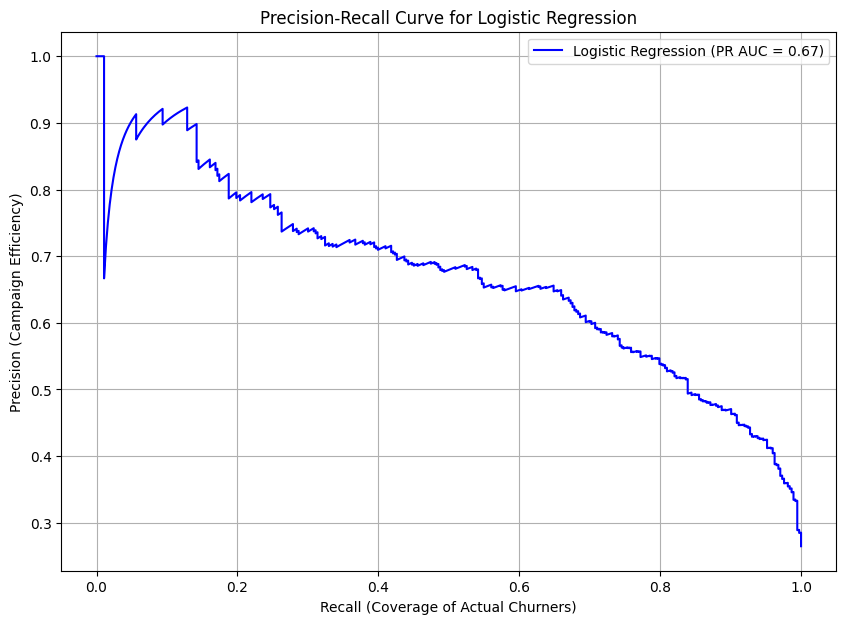

Precision-Recall AUC for Logistic Regression: 0.6702

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 270 -> Cost: $13,500.00
False Negatives (FN): 71 -> Cost: $142,000.00
Total Business Cost: $155,500.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.0736
Minimum Achievable Business Cost: $41,150.00

--- Cost-Sensitive Analysis at Threshold = 0.07360566337086195 ---
False Positives (FP): 743 -> Cost: $37,150.00
False Negatives (FN): 2 -> Cost: $4,000.00
Total Business Cost: $41,150.00


np.int64(41150)

In [8]:
# define Business costs
COST_FP = 50
COST_FN = 2000

y_probs_lr = model_lr.predict_proba(X_test)[: , 1]

# create instnce of the evaluator
lr_evaluator = BusinessModelEvaluator(
                                    Y_test,
                                    y_probs_lr,
                                    'Logistic Regression'
                                    )

lr_evaluator.plot_precision_recall_curve()
lr_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN) # Cost at default 0.5 threshold
optimal_thresh, min_cost = lr_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
lr_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh) # Cost at optimal threshold

That means to get a minimum error cost we need to adjust the threashold from 0.5 to 0.07

## 3.2 Train with Decicion Tree Model 🌲

In [9]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

#### 3.2.1 Inference

In [10]:
Y_hat_test = model_dt.predict(X_test)

#### 3.2.2 Evaluate the model with primary metrics

In [12]:
Classification_report = classification_report(Y_test, Y_hat_test)
print("\nClassification Report:")
print(Classification_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1036
           1       0.47      0.51      0.49       373

    accuracy                           0.72      1409
   macro avg       0.64      0.65      0.65      1409
weighted avg       0.73      0.72      0.72      1409



#### 3.2.3 Evaluate the model with Business Metrics


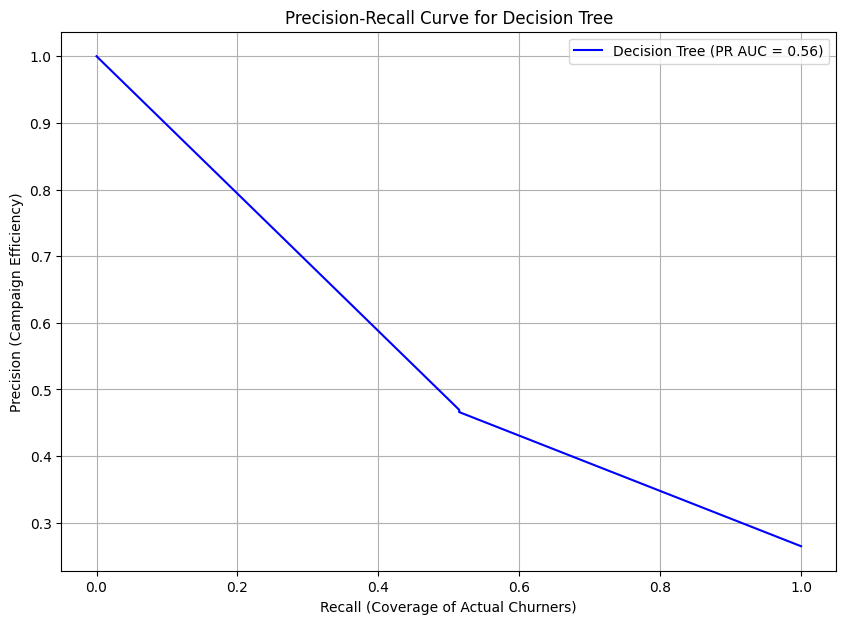

Precision-Recall AUC for Decision Tree: 0.5555

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 219 -> Cost: $10,950.00
False Negatives (FN): 181 -> Cost: $362,000.00
Total Business Cost: $372,950.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.0000
Minimum Achievable Business Cost: $51,800.00

--- Cost-Sensitive Analysis at Threshold = 0.0 ---
False Positives (FP): 1036 -> Cost: $51,800.00
False Negatives (FN): 0 -> Cost: $0.00
Total Business Cost: $51,800.00


np.int64(51800)

In [13]:
COST_FP = 50
COST_FN = 2000

y_probs_dt = model_dt.predict_proba(X_test)[: , 1]

# create instnce of the evaluator for model_dr
dt_evaluator = BusinessModelEvaluator(
                                    Y_test,
                                    y_probs_dt,
                                    'Decision Tree'
                                    )

dt_evaluator.plot_precision_recall_curve()
dt_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN) # Cost at default 0.5 threshold
optimal_thresh, min_cost = dt_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
dt_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh) # Cost at optimal threshold